# Overview

This notebook describes the different stages to build up different machine learning models trained over the dataset called **ISOT** by using pretrained **BERT** Embeddings, for the automatic fake news detection

List of Machine Learning algorithms included 
- SVM
- Random Forest
- XgBoost
- KNN
- Naive Bayes
- Logistic Regression



## 1. Loading Python libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tensorflow_hub as hub
import tensorflow_text
import tldextract   # Accurately separates a URL's subdomain, domain, and public suffix
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from imblearn.over_sampling import SMOTE,ADASYN
from collections import Counter
import nltk 
import spacy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from sklearn.metrics import f1_score
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 1000)

2022-07-08 15:45:58.009740: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-08 15:45:59.427100: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-07-08 15:45:59.427155: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Download

#### Loading the ISOT Full Dataset  -- After combined fake and real news  in the previous notebook   "ISOT_ML_Classifiers_TfiDF_Tokeniser"

In [2]:
isot_full_df = pd.read_csv("Updated//ISOT_Combined_FullData.csv")

#### Dropping the columns 'title' , 'text' and 'date'

In [3]:
isot_full_df = isot_full_df.drop(columns = ['title','text', 'subject','date','title_length','body_length','date'])

In [4]:
isot_full_df=isot_full_df.reset_index(drop=True)

***

## 2. Model Training and Evaluation

### BERT Embeddings

Next step is extract features from the news text column using pretrained BERT embeddings model

###### Create a pandas series dataframe which consists only fulltext column values

In [7]:
texts=isot_full_df['fulltext']

##### Download the Pretrained BERT embedding preprocessor and encoder  model from tensorflow hub

In [21]:
# bert preprocessor - https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
# bert encoder - https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/2
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/2",trainable=True)

2022-06-20 00:16:47.412807: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-20 00:16:47.413205: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-20 00:16:47.413505: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.
Since our dataset is huge and it is not possible to transform full data to numeric token ids , we can do the same by splitting the data into multiple chunks as like below

**First set** =  Create a first chunk of text series dataframe with first 10000 rows

In [12]:
# preprocessing dataset  - First Set
inputs = preprocessor(texts[0:10000])

After executing the above command, 3 outputs from the preprocessing will be generated that a BERT model would use (input_words_id, input_mask and input_type_ids).
Then encode the output and convert it into bert model features which can be feed to the model

In [ ]:
# feeding it to model for vectorization
outputs = encoder(inputs)

The above output BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs:

- pooled_output represents each input sequence as a whole. The shape is [batch_size, H]. 
- sequence_output represents each input token in the context. The shape is [batch_size, seq_length, H]. 
- encoder_outputs are the intermediate activations of the L Transformer block


In [13]:
pooled_output = outputs["pooled_output"]      # [batch_size, 512].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 512].

Then convert bert encoder sequence outputs to 1 dimension  and save the encoder sequence output to a dataframe for a single chunk.This same process need to do for all the splitted data chunks and then need to merge all the dataframes into a single one , which will feed to the model training

In [14]:
# defining dataframe
bertf_df1=pd.DataFrame()

In [15]:
## Converting bert encoder sequence output to 1 dimension for ML Model training
for i in range(0,len(sequence_output)):
    b=sequence_output[i].numpy().sum(axis=0)
    bertf_df1=bertf_df1.append(pd.Series(b),ignore_index=True)
print('values added in dataframe')

values added in dataframe


**Second set** =  Create a next chunk of text series dataframe ranging from 10000 to 20000

In [9]:
# preprocessing dataset  - First Set
inputs2 = preprocessor(texts[10000:20000])
# feeding it to model for vectorization
outputs2 = encoder(inputs2)

In [10]:
pooled_output2 = outputs2["pooled_output"]      # [batch_size, 512].
sequence_output2 = outputs2["sequence_output"]  # [batch_size, seq_length, 512].

In [11]:
# defining dataframe
bertf_df2=pd.DataFrame()

In [12]:
## Converting bert encoder sequence output to 1 dimension for ML Model training

for i in range(0,len(sequence_output2)):
    b=sequence_output2[i].numpy().sum(axis=0)
    bertf_df2=bertf_df2.append(pd.Series(b),ignore_index=True)
print('values added in dataframe')

values added in dataframe


**Third set** =  Create a next chunk of text series dataframe ranging from 10000 to 20000

In [14]:
# preprocessing dataset  - First Set
inputs3 = preprocessor(texts[20000:30000])
# feeding it to model for vectorization
outputs3 = encoder(inputs3)

In [15]:
pooled_output3 = outputs3["pooled_output"]      # [batch_size, 512].
sequence_output3 = outputs3["sequence_output"]  # [batch_size, seq_length, 512].

In [16]:
# defining dataframe
bertf_df3=pd.DataFrame()

In [17]:
## Converting bert encoder sequence output to 1 dimension for ML Model training

for i in range(0,len(sequence_output3)):
    b=sequence_output3[i].numpy().sum(axis=0)
    bertf_df3=bertf_df3.append(pd.Series(b),ignore_index=True)
print('values added in dataframe')

values added in dataframe


**Fourth set** =  Create a next chunk of text series dataframe ranging from 10000 to 20000

In [9]:
# preprocessing dataset  - First Set
inputs4 = preprocessor(texts[30000:40000])
# feeding it to model for vectorization
outputs4 = encoder(inputs4)

In [10]:
pooled_output4 = outputs4["pooled_output"]      # [batch_size, 512].
sequence_output4 = outputs4["sequence_output"]  # [batch_size, seq_length, 512].

In [11]:
# defining dataframe
bertf_df4=pd.DataFrame()

In [12]:
## Converting bert encoder sequence output to 1 dimension for ML Model training

for i in range(0,len(sequence_output4)):
    b=sequence_output4[i].numpy().sum(axis=0)
    bertf_df4=bertf_df4.append(pd.Series(b),ignore_index=True)
print('values added in dataframe')

values added in dataframe


Merge all the bert feature dataframes into a single one , which will feed to the model training

In [9]:
# merging both props 
bertVectors_fulldf=pd.concat([bertf_df1,bertf_df2,bertf_df3,bertf_df4])
bertVectors_fulldf.reset_index(drop=True,inplace=True)

Then add class label column in the merged bert feature dataframe and then this dataframe will go with train-test data splitting

In [13]:
bertVectors_fulldf.insert(len(bertVectors_fulldf.columns),'class',isot_full_df['class'])

In [14]:
bertVectors_fulldf['class'].value_counts()

0    20820
1    17450
Name: class, dtype: int64

#### Convert Bertvectors dataframe  to CSV format  and store in a path

In [ ]:
bertVectors_fulldf.to_csv('Updated//bertVectors_fulldf_ISOT.csv', index=False)

#### Splitting bert vectors dataframe into features and class 

In [7]:
X=bertVectors_fulldf.drop('class',axis=1)
y=bertVectors_fulldf['class']

#### Using StratifiedKFold technique to create X_train , X_test, Y_train and Y_test

In [8]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [9]:
for i, j in kfold.split(X, y):
    # select rows
    X_train, X_test = X.iloc[i], X.iloc[j]
    y_train, y_test = y.iloc[i], y.iloc[j]

####  User defined helper functions to find out the accuracy score metrics and creation of model comparison table


- The function named **metrics** is using to calculate the score of the different metrics such as Accuracy, Precision, Recall, F1Score and ROC AUC score for the given classifier with test data


- The function named **model_comparison_table** is using to create dataframe to list down all the classifiers with the metrics scores for the comparison purpose

In [11]:
import timeit
from timeit import default_timer as timer
from datetime import timedelta
 


def metrics(X_test,y_test,clf):
    predictions=clf.predict(X_test)
    #predictions=(clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool)
    print("confusion_matrix :")
    print(confusion_matrix(y_test,predictions))
    print("Accuracy Score :")
    print(accuracy_score(y_test, predictions))
    print("Classification Report :")
    print(classification_report(y_test, predictions))
    print("F1 score :")
    print(f1_score(y_test, predictions))
    print("ROC AUC Score")
    y_pred_proba = clf.predict_proba(X_test)
    print(roc_auc_score(y_test, y_pred_proba[:,1]) )
    print("------------------------------")

    
def model_comparison_table(X_test,y_test,classifier_list):
    dict_clf={}
    for clf_name,clf in classifier_list:
        predictions=clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)
        accuracy=accuracy_score(y_test, predictions)
        precision=precision_score(y_test,predictions,average='macro').round(2)
        recall=recall_score(y_test,predictions)
        f1score=f1_score(y_test,predictions).round(2)
        ROC_AUC=roc_auc_score(y_test, y_pred_proba[:,1])
        dict_clf[clf_name]=[accuracy,precision,recall,f1score,ROC_AUC]
    df_models_scores = pd.DataFrame(dict_clf, index=['Accuracy', 'Precision', 'Recall', 'F1 Score','roc_auc_score'])
    return df_models_scores

#### User defined helper functions to create the confusion matrix and normalised confusion matrix 

The below scripts is using to create the confusion matrix and normalised confusion matrix based on the predictions and actual truth lables


In [12]:
# Helper function to plot confusion matrix and normalised confusion matrix plot
def confusn_mtrx_plot(cm,path):
    from sklearn.metrics import confusion_matrix
    # Y_pred_evc = evc_mdl.predict(test_X)
    #cm = confusion_matrix(ytrue, y_pred)

    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="GnBu", fmt="g");  
    #sns.heatmap(cm/np.sum(cm), annot=True, ax=ax[1], cmap="GnBu", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    #fig.show()
    fig.savefig(path)
    
def norm_confusn_mtrx_plot(cm,path):
    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm/np.sum(cm), annot=True, ax=ax, cmap="GnBu",fmt='.2%');  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'18'}  # Adjust to fit
    ax.set_title('Normalised Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    fig.savefig(path)

***

## Random Forest

**Initialise Random Forest model and  fit using train data and save the model**

In [13]:
# Instantiate and fit a basic Random Forest model on top of the vectors
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf_model = rf.fit(X_train, y_train)

import pickle
# save the model to disk
filename = 'outputs//isot_ml_bert//isot_ml_RF_bert.sav'
pickle.dump(rf_model, open(filename, 'wb'))
print('RandomForest - Completed')

RandomForest - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [14]:
#Loading the model
filename = 'outputs//isot_ml_bert//isot_ml_RF_bert.sav'

rf_clf_tuned = pickle.load(open(filename, 'rb'))

pred = rf_clf_tuned.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.9380715965508231
Confusion matrix : 
 [[3992  172]
 [ 302 3188]]
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      4164
           1       0.95      0.91      0.93      3490

    accuracy                           0.94      7654
   macro avg       0.94      0.94      0.94      7654
weighted avg       0.94      0.94      0.94      7654

Precision : 0.9488095238095238
Recall : 0.9134670487106017
F1 Score : 0.9308029197080291


**Save the classification report to csv**

In [15]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_ml_bert//model_ISOT_RF_BERT_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.929669,0.958694,0.943958,4164.000000
1,0.948810,0.913467,0.930803,3490.000000
accuracy,0.938072,0.938072,0.938072,0.938072
macro avg,0.939239,0.936080,0.937381,7654.000000
weighted avg,0.938397,0.938072,0.937960,7654.000000


**Plot confusion matrix using the user defined functions created earlier**

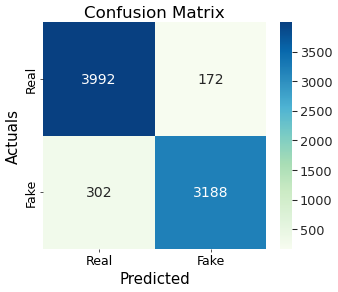

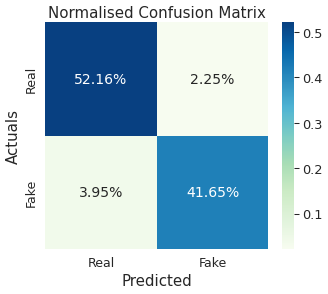

In [17]:
cm=confusion_matrix(y_test, pred)
path1="outputs//isot_ml_bert//isot_ml_RF_bert_cmtrx.png"
path2="outputs//isot_ml_bert//isot_ml_RF_bert_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Support Vector Machine

**Initialise the model and  fit using train data and save the model**

In [18]:
svm_clf=SVC(random_state=0,probability=True)

In [19]:
svm_clf.fit(X_train, y_train)

# save the model to disk
filename = 'outputs//isot_ml_bert//isot_ml_SVM_bert.sav'
pickle.dump(svm_clf, open(filename, 'wb'))
print('SVM - Completed')

SVM - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [20]:
#Loading the model
filename = 'outputs//isot_ml_bert//isot_ml_SVM_bert.sav'

svm_clf_tuned = pickle.load(open(filename, 'rb'))

pred = svm_clf_tuned.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.9760909328455709
Confusion matrix : 
 [[4089   75]
 [ 108 3382]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4164
           1       0.98      0.97      0.97      3490

    accuracy                           0.98      7654
   macro avg       0.98      0.98      0.98      7654
weighted avg       0.98      0.98      0.98      7654

Precision : 0.9783048886317617
Recall : 0.969054441260745
F1 Score : 0.9736576939686196


**Save the classification report to csv**

In [21]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_ml_bert//model_ISOT_SVM_BERT_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.974267,0.981988,0.978113,4164.000000
1,0.978305,0.969054,0.973658,3490.000000
accuracy,0.976091,0.976091,0.976091,0.976091
macro avg,0.976286,0.975521,0.975885,7654.000000
weighted avg,0.976108,0.976091,0.976081,7654.000000


**Plot confusion matrix using the user defined functions created earlier**

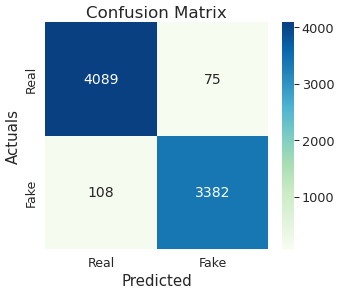

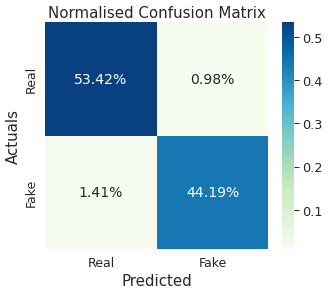

In [23]:
cm=confusion_matrix(y_test, pred)
path1="outputs//isot_ml_bert//isot_ml_SVM_bert_cmtrx.png"
path2="outputs//isot_ml_bert//isot_ml_SVM_bert_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

## KNN
**Initialise the model and  fit using train data and save the model**

In [24]:
#Create KNN Object.
knn_clf = KNeighborsClassifier()

In [25]:
knn_clf.fit(X_train,y_train)

# save the model to disk
filename = 'outputs//isot_ml_bert//isot_ml_KNN_bert.sav'
pickle.dump(svm_clf, open(filename, 'wb'))
print('KNN - Completed')

KNN - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [26]:
#Loading the model
filename = 'outputs//isot_ml_bert//isot_ml_KNN_bert.sav'

knn_clf_tuned = pickle.load(open(filename, 'rb'))

pred = knn_clf_tuned.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.9760909328455709
Confusion matrix : 
 [[4089   75]
 [ 108 3382]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4164
           1       0.98      0.97      0.97      3490

    accuracy                           0.98      7654
   macro avg       0.98      0.98      0.98      7654
weighted avg       0.98      0.98      0.98      7654

Precision : 0.9783048886317617
Recall : 0.969054441260745
F1 Score : 0.9736576939686196


**Save the classification report to csv**

In [27]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_ml_bert//model_ISOT_KNN_BERT_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.974267,0.981988,0.978113,4164.000000
1,0.978305,0.969054,0.973658,3490.000000
accuracy,0.976091,0.976091,0.976091,0.976091
macro avg,0.976286,0.975521,0.975885,7654.000000
weighted avg,0.976108,0.976091,0.976081,7654.000000


**Plot confusion matrix using the user defined functions created earlier**

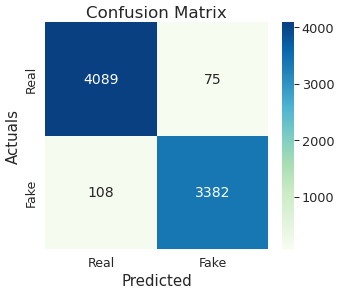

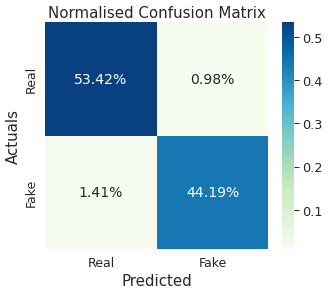

In [29]:
cm=confusion_matrix(y_test, pred)
path1="outputs//isot_ml_bert//isot_ml_KNN_bert_cmtrx.png"
path2="outputs//isot_ml_bert//isot_ml_KNN_bert_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Xgboost
**Initialise the model and  fit using train data and save the model**

In [30]:
#Create KNN Object.
xg_clf=XGBClassifier(random_state=0)

xg_clf.fit(X_train,y_train)

# save the model to disk
filename = 'outputs//isot_ml_bert//isot_ml_XG_bert.sav'
pickle.dump(svm_clf, open(filename, 'wb'))
print('XgBoost - Completed')

XgBoost - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [31]:
#Loading the model
filename = 'outputs//isot_ml_bert//isot_ml_XG_bert.sav'

xg_clf_tuned = pickle.load(open(filename, 'rb'))

pred = xg_clf_tuned.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.9760909328455709
Confusion matrix : 
 [[4089   75]
 [ 108 3382]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4164
           1       0.98      0.97      0.97      3490

    accuracy                           0.98      7654
   macro avg       0.98      0.98      0.98      7654
weighted avg       0.98      0.98      0.98      7654

Precision : 0.9783048886317617
Recall : 0.969054441260745
F1 Score : 0.9736576939686196


**Save the classification report to csv**

In [32]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_ml_bert//model_ISOT_XG_BERT_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.974267,0.981988,0.978113,4164.000000
1,0.978305,0.969054,0.973658,3490.000000
accuracy,0.976091,0.976091,0.976091,0.976091
macro avg,0.976286,0.975521,0.975885,7654.000000
weighted avg,0.976108,0.976091,0.976081,7654.000000


**Plot confusion matrix using the user defined functions created earlier**

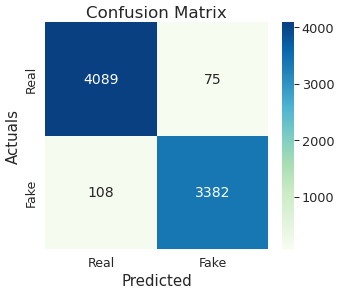

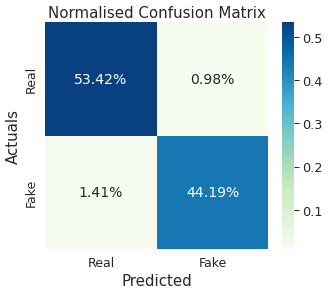

In [34]:
cm=confusion_matrix(y_test, pred)
path1="outputs//isot_ml_bert//isot_ml_XG_bert_cmtrx.png"
path2="outputs//isot_ml_bert//isot_ml_XG_bert_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Naive Bayes

**Initialise the model and  fit using train data and save the model**

In [35]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
nb_clf=GaussianNB()
#p = Pipeline([('Normalizing',MinMaxScaler()),('MultinomialNB',MultinomialNB())])
nb_clf.fit(X_train,y_train) 

# save the model to disk
filename = 'outputs//isot_ml_bert//isot_ml_NB_bert.sav'
pickle.dump(nb_clf, open(filename, 'wb'))
print('Naive Bayes - Completed')

Naive Bayes - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [36]:
#Loading the model
filename = 'outputs//isot_ml_bert//isot_ml_NB_bert.sav'

nb_clf_tuned = pickle.load(open(filename, 'rb'))

pred = nb_clf_tuned.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.9178207473216619
Confusion matrix : 
 [[3895  269]
 [ 360 3130]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      4164
           1       0.92      0.90      0.91      3490

    accuracy                           0.92      7654
   macro avg       0.92      0.92      0.92      7654
weighted avg       0.92      0.92      0.92      7654

Precision : 0.9208590761988821
Recall : 0.8968481375358166
F1 Score : 0.9086950210480476


**Save the classification report to csv**

In [37]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_ml_bert//model_ISOT_NB_BERT_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.915394,0.935399,0.925288,4164.000000
1,0.920859,0.896848,0.908695,3490.000000
accuracy,0.917821,0.917821,0.917821,0.917821
macro avg,0.918126,0.916123,0.916992,7654.000000
weighted avg,0.917886,0.917821,0.917722,7654.000000


**Plot confusion matrix using the user defined functions created earlier**

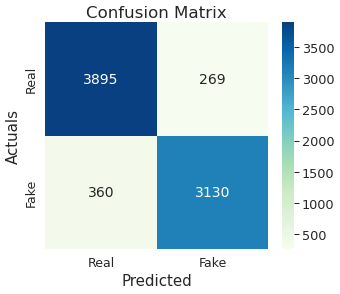

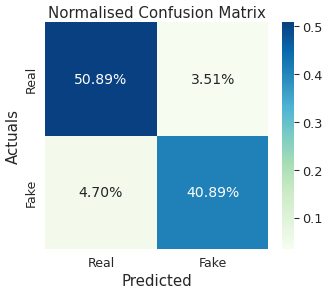

In [39]:
cm=confusion_matrix(y_test, pred)
path1="outputs//isot_ml_bert//isot_ml_NB_bert_cmtrx.png"
path2="outputs//isot_ml_bert//isot_ml_NB_bert_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Logistic Regression

**Initialise the model and  fit using train data and save the model**

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
logticreg_clf=LogisticRegression()

logticreg_clf.fit(X_train,y_train)

# save the model to disk
filename = 'outputs//isot_ml_bert//isot_ml_LR_bert.sav'
pickle.dump(nb_clf, open(filename, 'wb'))
print('Logistic Regression - Completed')

Logistic Regression - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [42]:
#Loading the model
filename = 'outputs//isot_ml_bert//isot_ml_LR_bert.sav'

lr_clf_tuned = pickle.load(open(filename, 'rb'))

pred = lr_clf_tuned.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.9178207473216619
Confusion matrix : 
 [[3895  269]
 [ 360 3130]]
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      4164
           1       0.92      0.90      0.91      3490

    accuracy                           0.92      7654
   macro avg       0.92      0.92      0.92      7654
weighted avg       0.92      0.92      0.92      7654

Precision : 0.9208590761988821
Recall : 0.8968481375358166
F1 Score : 0.9086950210480476


**Save the classification report to csv**

In [43]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_ml_bert//model_ISOT_LR_BERT_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.915394,0.935399,0.925288,4164.000000
1,0.920859,0.896848,0.908695,3490.000000
accuracy,0.917821,0.917821,0.917821,0.917821
macro avg,0.918126,0.916123,0.916992,7654.000000
weighted avg,0.917886,0.917821,0.917722,7654.000000


**Plot confusion matrix using the user defined functions created earlier**

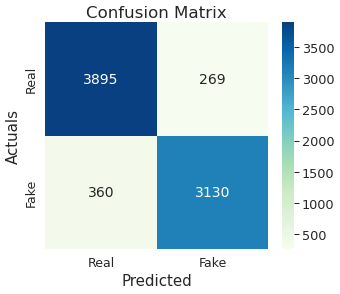

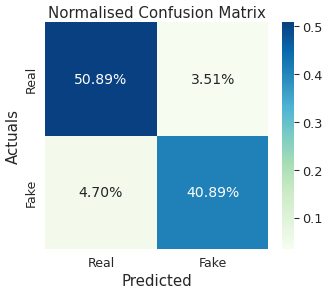

In [45]:
cm=confusion_matrix(y_test, pred)
path1="outputs//isot_ml_bert//isot_ml_LR_bert_cmtrx.png"
path2="outputs//isot_ml_bert//isot_ml_LR_bert_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### ROC AUC Curve plot based on the scores of all the algorithms

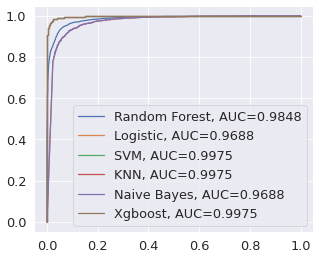

In [47]:
#set up plotting area
fig = plt.figure(figsize=(6, 5), dpi=60)
ax = plt.subplot()
#fit RF model and plot ROC curve

y_pred = rf_clf_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

#fit Logistic model and plot ROC curve

y_pred = lr_clf_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic, AUC="+str(auc))


#fit SVM model and plot ROC curve

y_pred = svm_clf_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="SVM, AUC="+str(auc))


#fit KNN model and plot ROC curve


y_pred = knn_clf_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))

#fit Naive Bayes model and plot ROC curve

y_pred = nb_clf_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Naive Bayes, AUC="+str(auc))

#fit Xgboost model and plot ROC curve

y_pred = xg_clf_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Xgboost, AUC="+str(auc))

#add legend
plt.legend()
fig.savefig("outputs//isot_ml_bert//ROC_AUC.png")

### Consolidating all classifiers accuracy scores

In [48]:
classifiers = [('Logistic Regression',lr_clf_tuned),('Naive Bayes',nb_clf_tuned),('Xgboost',xg_clf_tuned),
              ('KNN',knn_clf_tuned),('Random Forest',rf_clf_tuned),("SVM",svm_clf_tuned)]

In [49]:
df_model_scores=model_comparison_table(X_test,y_test,classifiers)
df_model_scores.head(20).T.sort_values(by='Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1 Score,roc_auc_score
Xgboost,0.976091,0.98,0.969054,0.97,0.997531
KNN,0.976091,0.98,0.969054,0.97,0.997531
SVM,0.976091,0.98,0.969054,0.97,0.997531
Random Forest,0.938072,0.94,0.913467,0.93,0.984804
Logistic Regression,0.917821,0.92,0.896848,0.91,0.968778
Naive Bayes,0.917821,0.92,0.896848,0.91,0.968778


In [50]:
df_model_scores.to_csv("outputs//isot_ml_bert/comparison_scores.csv")